# RISEI

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import show_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [5]:
import tensorflow as tf

RANDOM_SEED = 250398
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [6]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20201226-230136
Wall time: 6 ms


In [7]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
#     'l2_beta': None,
#     'dropout': 0.10,
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': False,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 200,
    'patience': 50,
    'tensorboard_update_freq': 'epoch', 
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
    'augmentations': True,
    'batch_size': 10,
#     'model_checkpoint_callback': False,
}

## Model

In [8]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 21, 17, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 17, 21, 17, 128)   2

In [9]:
load_checkpoint(model, DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL, '3d_cnn_v2.01', 'cp-0070.ckpt')

loading checkpoint from ../../tmp\bckp-checkpoints\3d_cnn_v2.01\cp-0070.ckpt...


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8035714285714286
recall: 0.7258064516129032
f1-score: 0.7627118644067797
support: 62


CN
precision: 0.6136363636363636
recall: 0.7105263157894737
f1-score: 0.6585365853658537
support: 38


micro avg
precision: 0.72
recall: 0.72
f1-score: 0.72
support: 100


macro avg
precision: 0.7086038961038961
recall: 0.7181663837011885
f1-score: 0.7106242248863167
support: 100


weighted avg
precision: 0.731396103896104
recall: 0.72
f1-score: 0.7231252583712279
support: 100


samples avg
precision: 0.72
recall: 0.72
f1-score: 0.72
support: 100


F1
micro: 0.72
macro: 0.7106242248863167


accuracy_score: 0.72
sensitivity_score: 0.7258064516129032
specificity_score: 0.7105263157894737


Wall time: 23.3 s


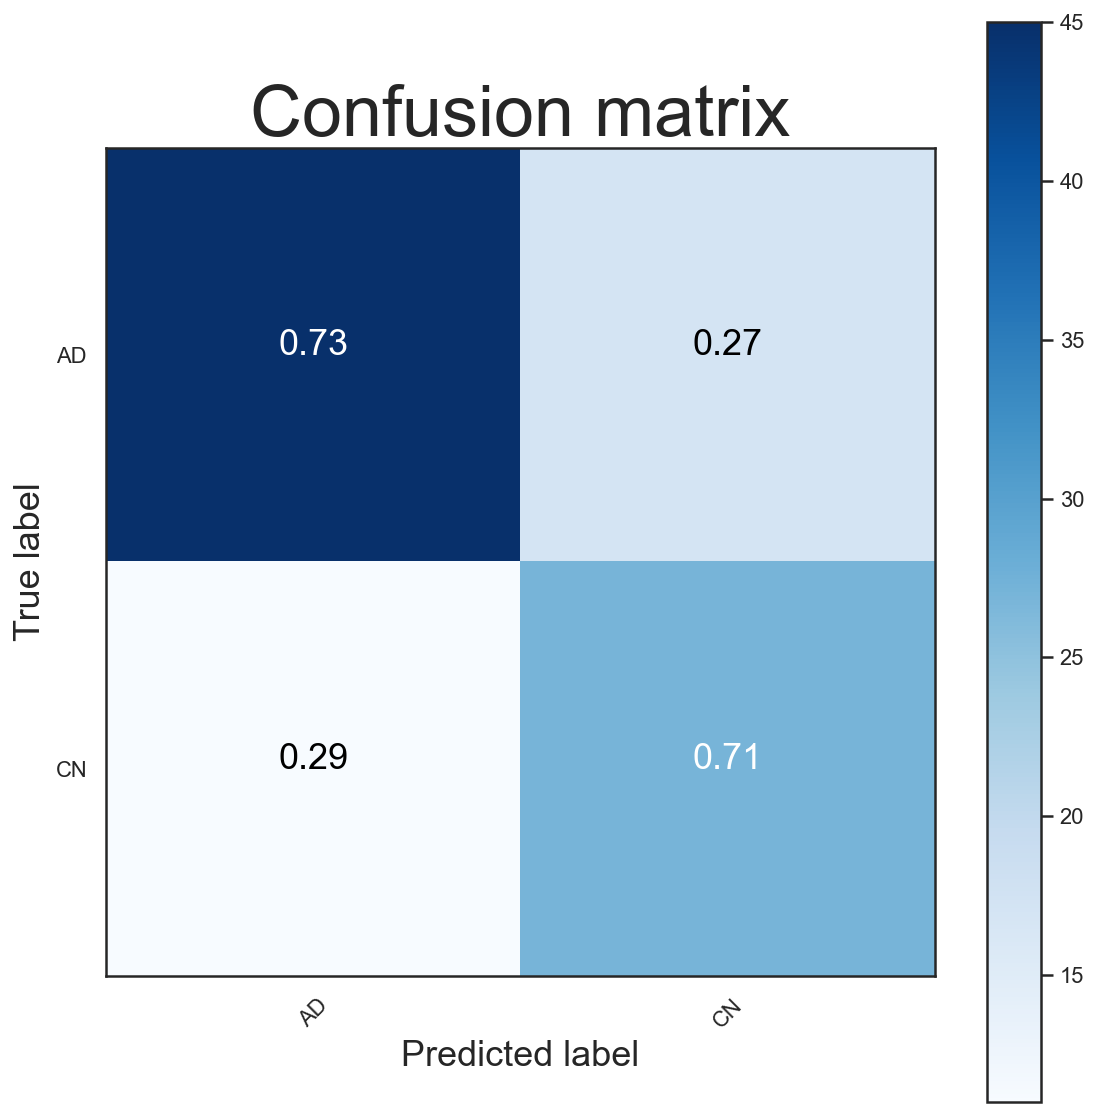

In [8]:
%%time

show_metrics(model, test_seq, class_names)

## RISEI

In [12]:
import SimpleITK as sitk

import src.heatmaps as heatmaps
import src.data.plot_image as plot_image

from src.heatmaps.evaluation import EvaluationSequence, plot_evaluation, predict_sequence_as_numpy

from src.risei import RISEI

In [11]:
idx = 4
batch_x, batch_y, *_ = train_seq[0]
image_x = batch_x[idx]
image_y = batch_y[idx]

In [33]:
# Create a RISEI instance with a config.
# RISEI accepts shape without channels!
#
# p1 = probability of white place to be transparent
# b1 = inpaint mask blend (0 disables inpainting)
# b2 = black mask blend

processes = 8
debug = True

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=1,
    b2=0.5, 
    in_paint='2d', 
    in_paint_blending=False, 
    in_paint_radius=5,
    in_paint_2d_to_3d=False,
    processes=processes, 
    debug=debug)

In [41]:
%%time

# get a heatmap for a prediciton
heatmap, masks_x, masks_y = heatmaps.get_heatmap(
    image_x,
    image_y,
    model,
    risei,
    batch_size=train_config['batch_size'],
    masks_count=1,
    risei_batch_size=480,
    seed=1,
    debug=debug,
    log=True)

Generating masks:   0%|          | 0/1 [00:00<?, ?it/s]


batch #0 of 1


Generating masks: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]




y_true: 0
Wall time: 3.89 s


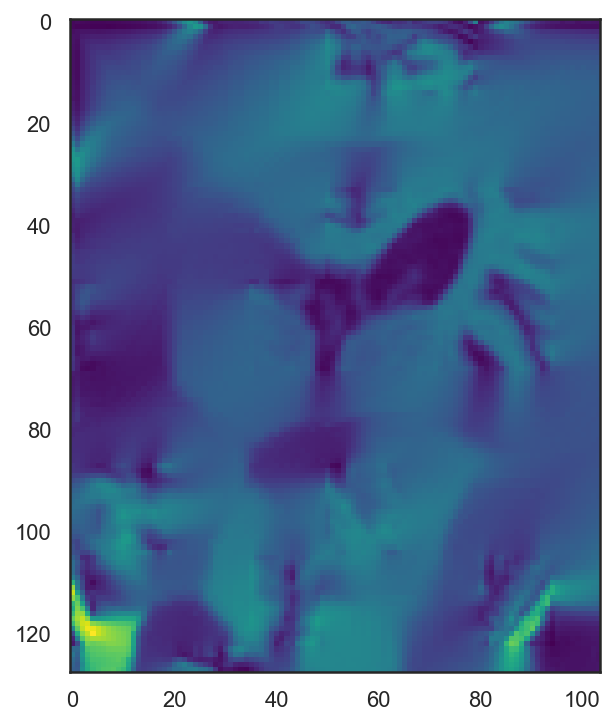

In [44]:
in_paint_2 = risei.show_in_paint_from_last_run(0, 56, dim=1)
plt.imshow(in_paint_1)

In [261]:
image_x.shape

(104, 128, 104, 1)

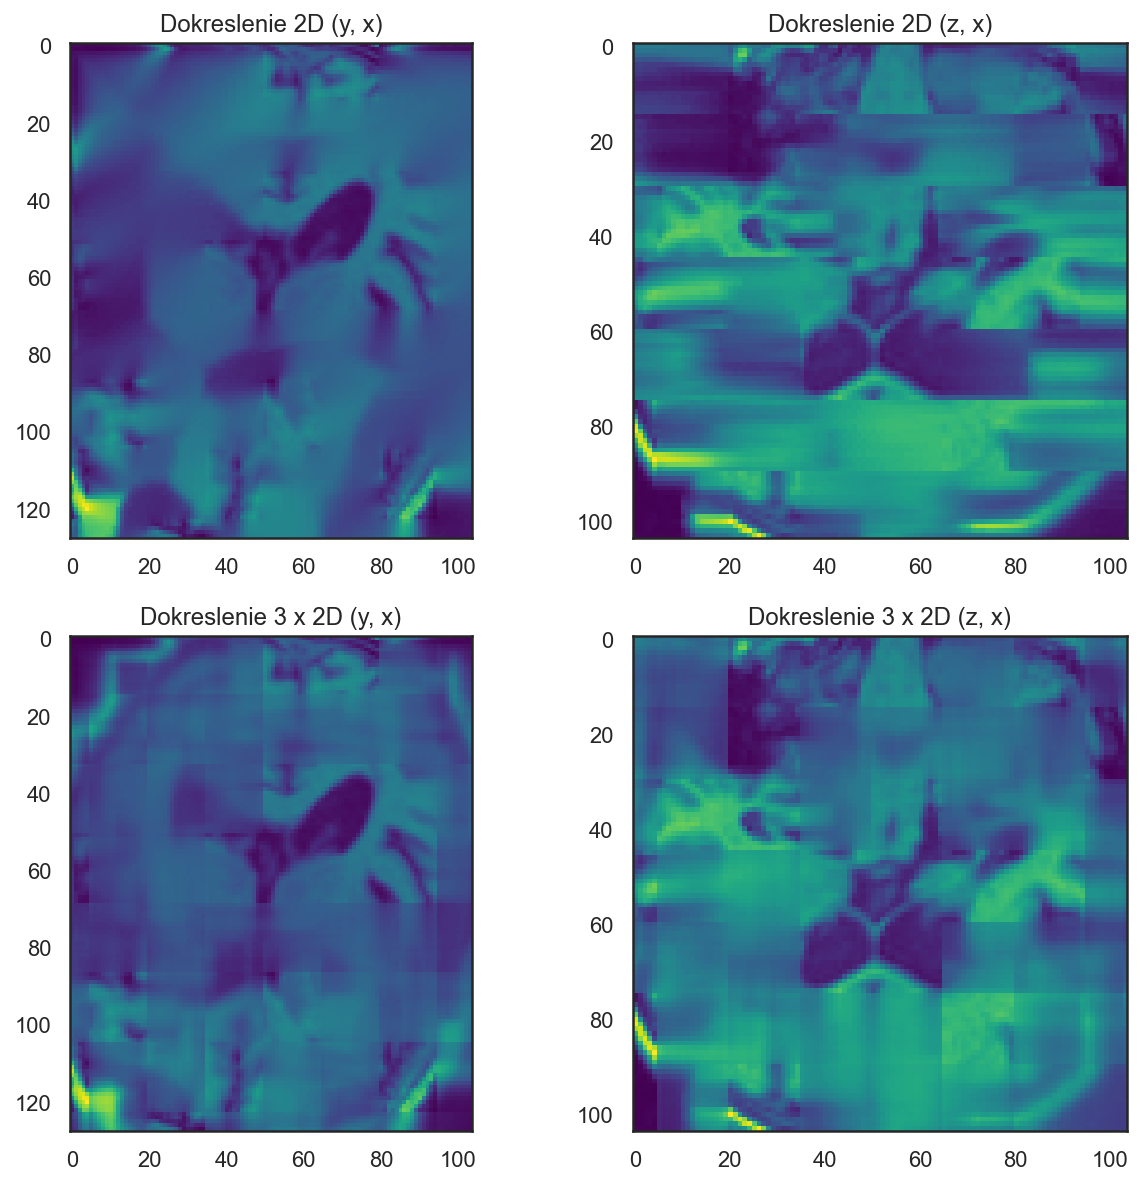

In [45]:
idx = 0

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title('Dokreslenie 2D (y, x)')
img = in_paint_1
plt.imshow(img)
plt.subplot(2, 2, 2)
plt.title('Dokreslenie 2D (z, x)')
img = in_paint_2
plt.imshow(img)

plt.subplot(2, 2, 3)
plt.title('Dokreslenie 3 x 2D (y, x)')
img = in_paint_3
plt.imshow(img)
plt.subplot(2, 2, 4)
plt.title('Dokreslenie 3 x 2D (z, x)')
img = in_paint_4
plt.imshow(img)

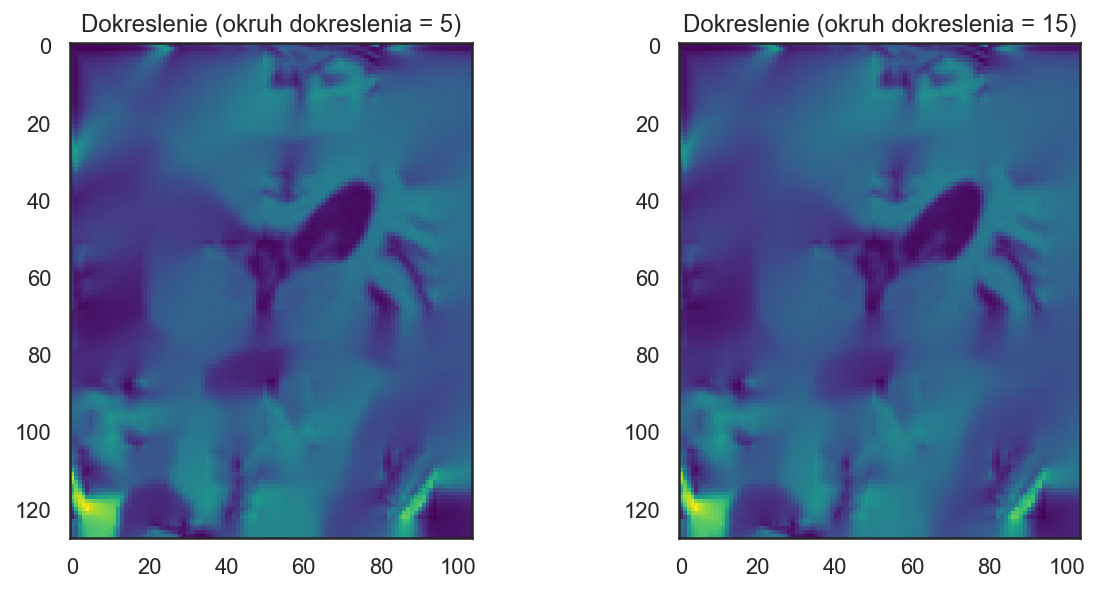

In [250]:
idx = 0

plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.title('Dokreslenie (okruh dokreslenia = 5)')
img = in_paint_1
plt.imshow(img)
plt.subplot(222)
plt.title('Dokreslenie (okruh dokreslenia = 15)')
img = in_paint_2
plt.imshow(img)

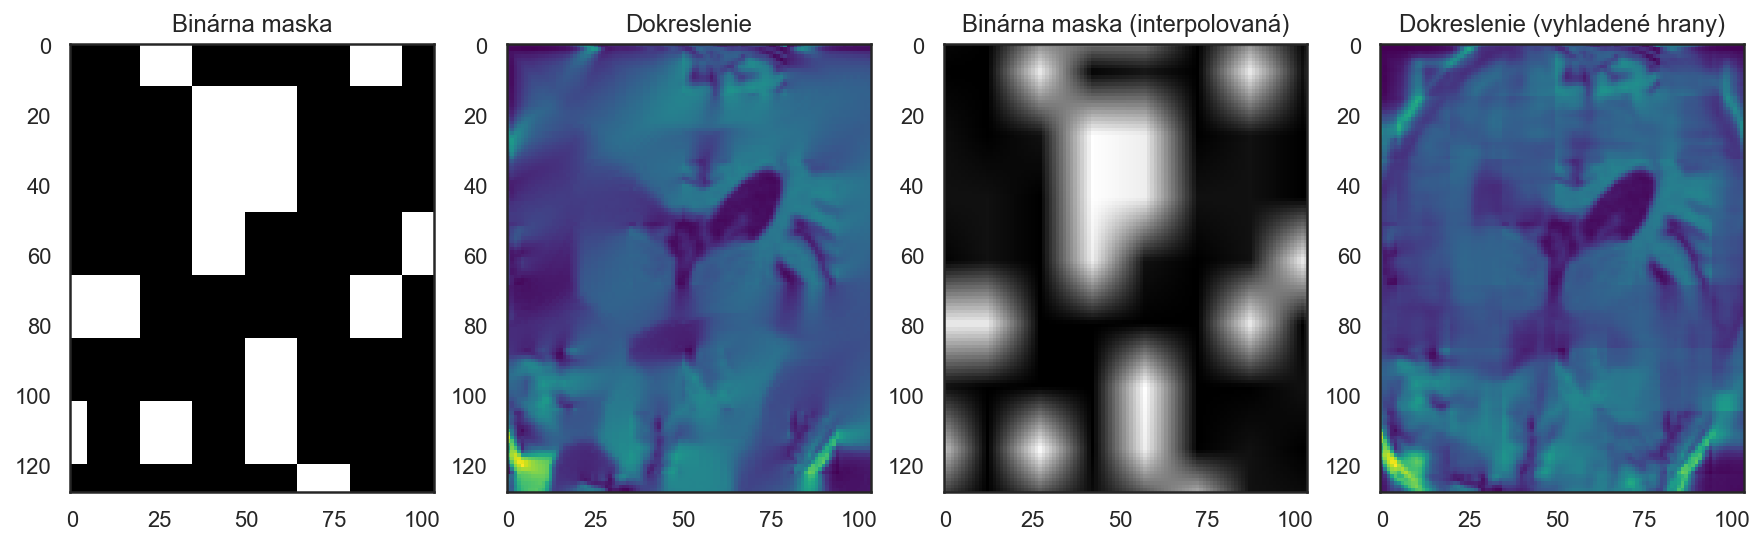

In [221]:
idx = 0

plt.figure(figsize=(15, 10))

plt.subplot(241)
plt.title('Binárna maska')
plt.imshow(risei2.show_binary_mask_from_last_run(0, 0, dim=0))

plt.subplot(243)
plt.title('Binárna maska (interpolovaná)')
plt.imshow(risei2.show_mask_from_last_run(0, 0, dim=0))
plt.subplot(242)
plt.title('Dokreslenie')
img = in_paint_1
plt.imshow(img)
plt.subplot(244)
plt.title('Dokreslenie (vyhladené hrany)')
img = in_paint_2
plt.imshow(img)

In [205]:
a = in_paint_2 - in_paint_1
a.max()

0.0

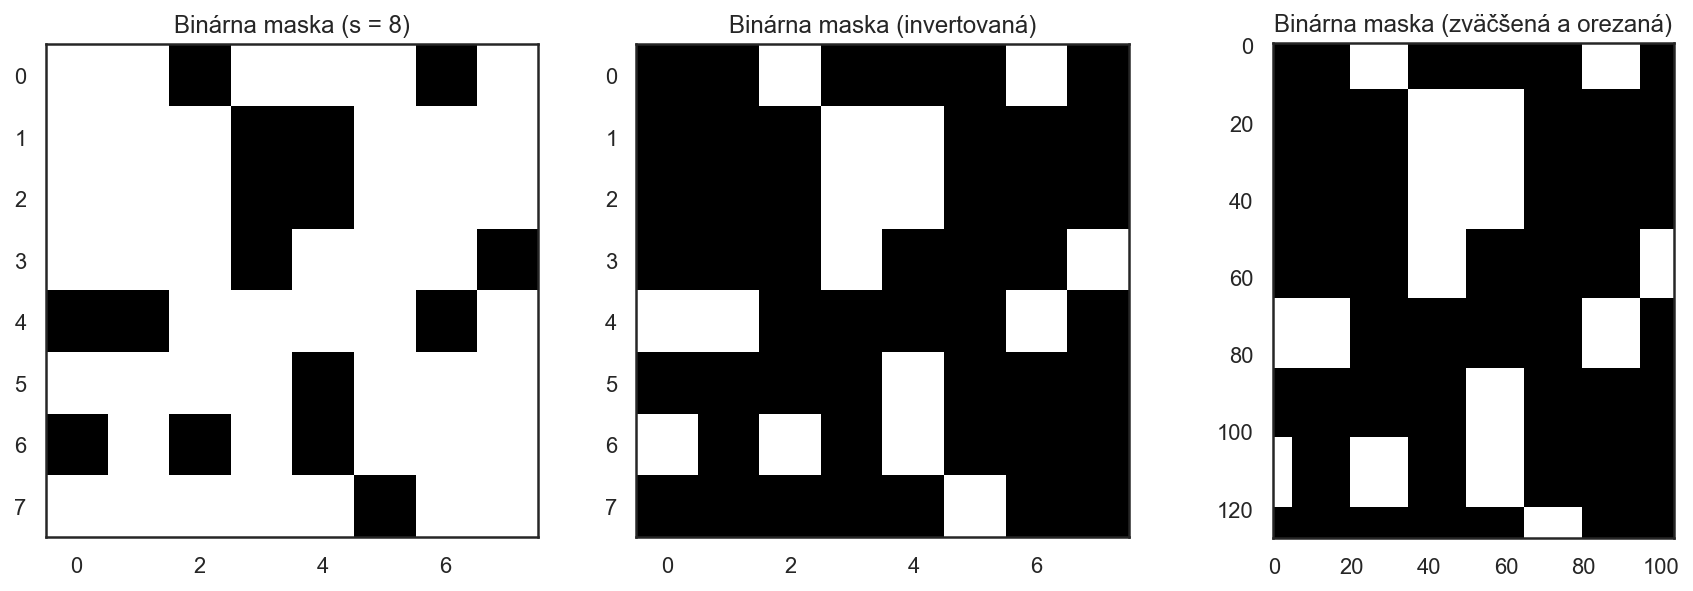

In [176]:
idx = 0

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Binárna maska (s = 8)')
img = risei2.cache['grids'][idx][0]
plt.imshow(img, cmap='binary')
plt.subplot(232)
plt.title('Binárna maska (invertovaná)')
img = 1 - risei2.cache['grids'][idx][0]
plt.imshow(img, cmap='binary')
plt.subplot(233)
plt.title('Binárna maska (zväčšená a orezaná)')
plt.imshow(risei2.show_binary_mask_from_last_run(0, 0, dim=0))

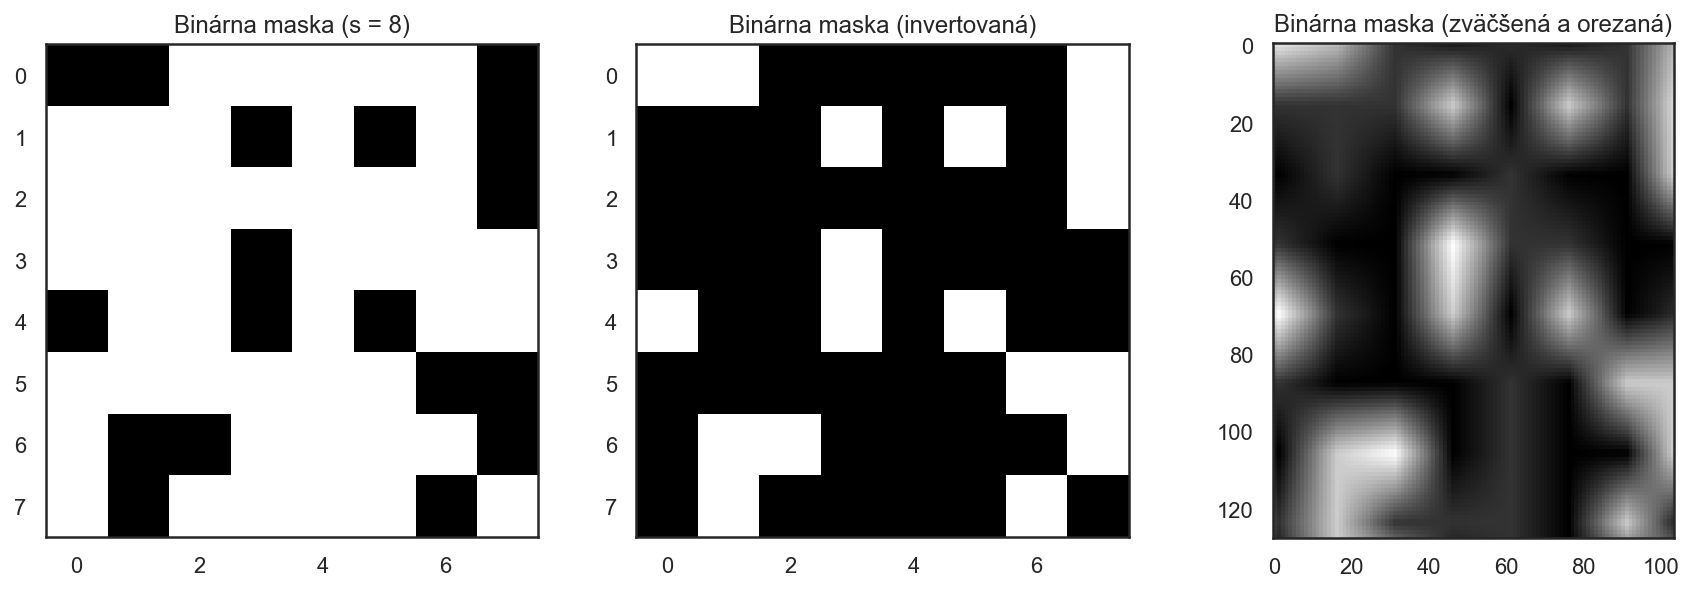

In [149]:
idx = 0

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Binárna maska (s = 8)')
img = risei2.cache['grids'][idx][0]
plt.imshow(img, cmap='binary')
plt.subplot(232)
plt.title('Binárna maska (invertovaná)')
img = 1 - risei2.cache['grids'][idx][0]
plt.imshow(img, cmap='binary')
plt.subplot(233)
plt.title('Binárna maska (zväčšená, interpolovaná a orezaná)')
plt.imshow(risei2.show_mask_from_last_run(0, 0, dim=0))

In [ ]:
 risei2.show_binary_mask_last_run(0, 0, dim=0)

In [144]:
image_x.shape

(104, 128, 104, 1)

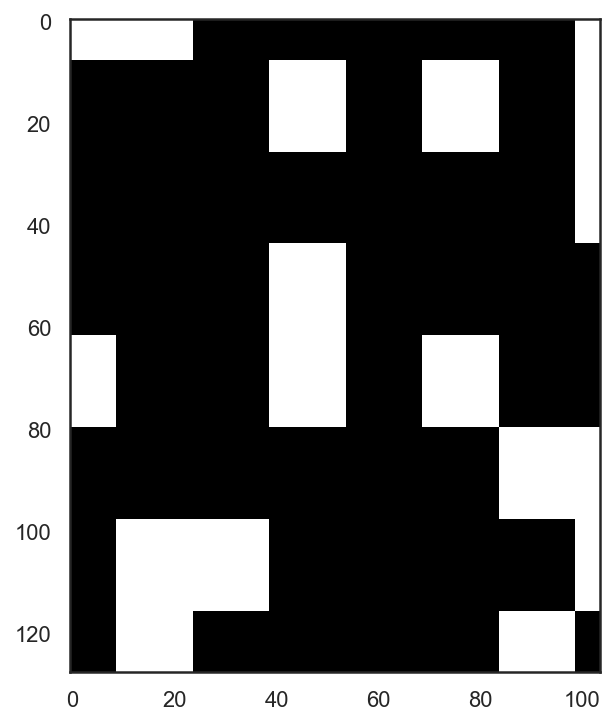

In [138]:
plt.imshow(risei2.show_binary_mask_from_last_run(0, 0, dim=0))

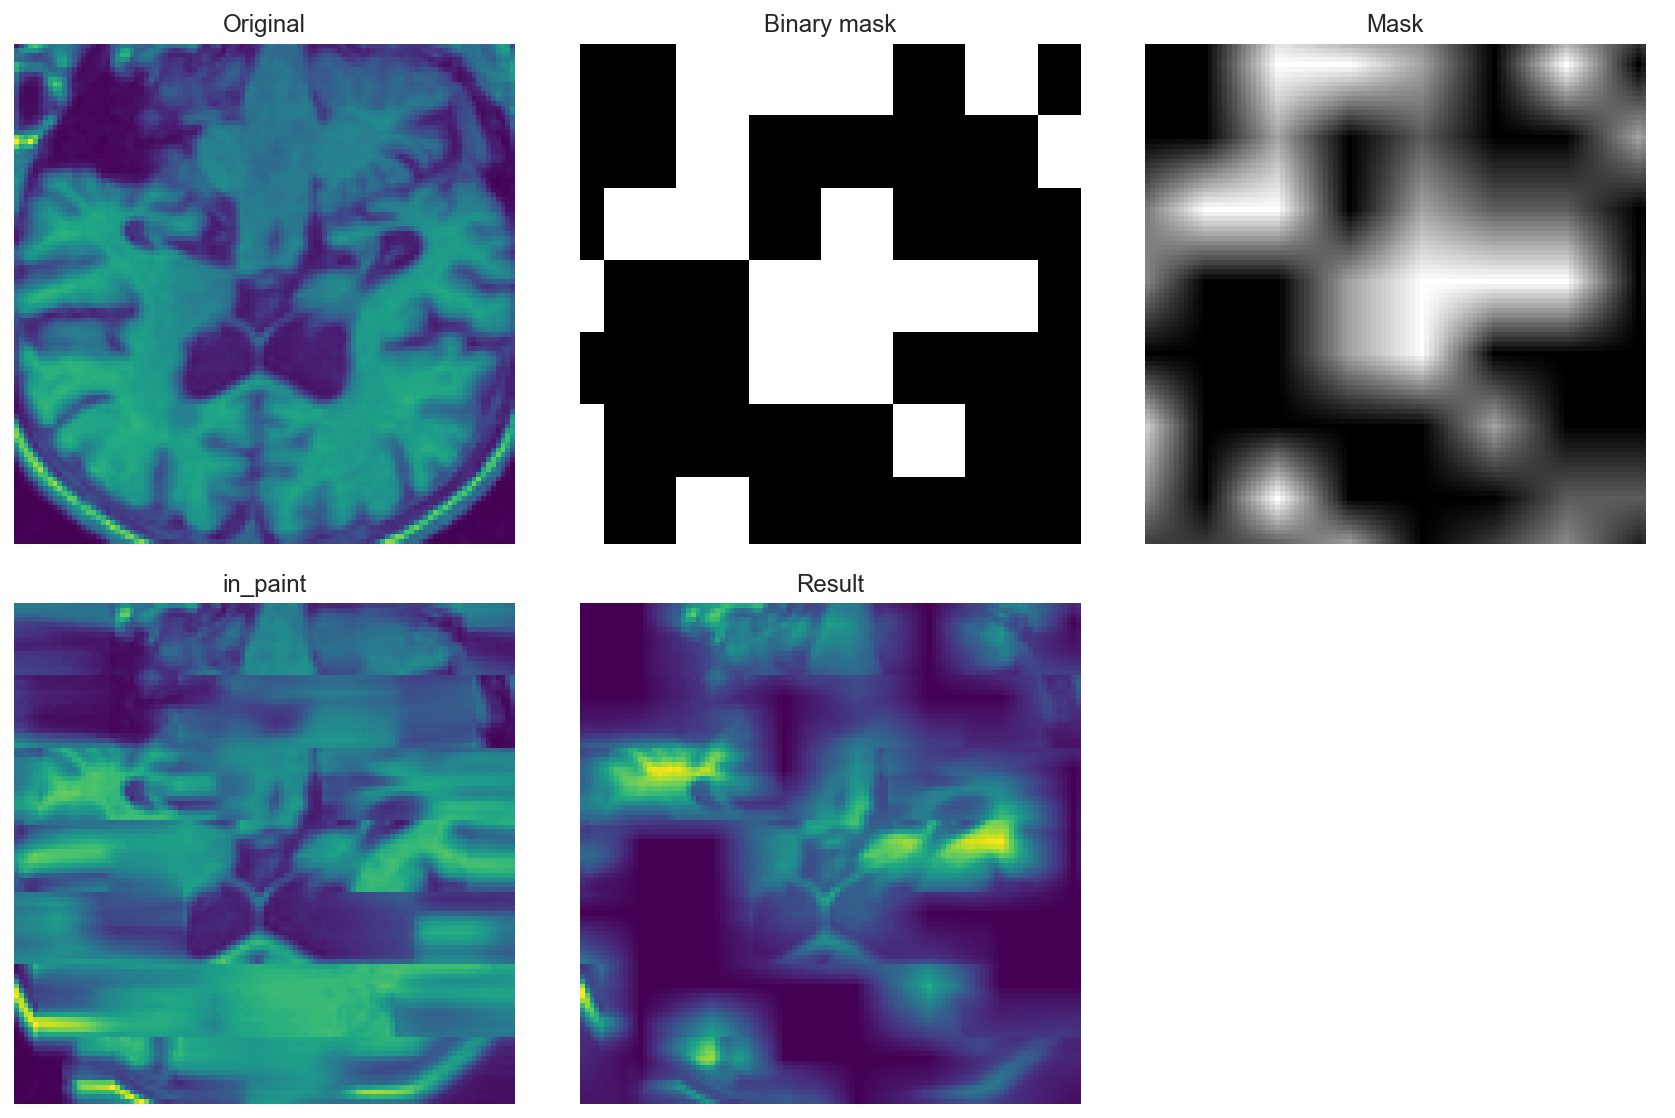

In [281]:
if debug:
    risei.show_from_last_run(0, 56, dim=1)

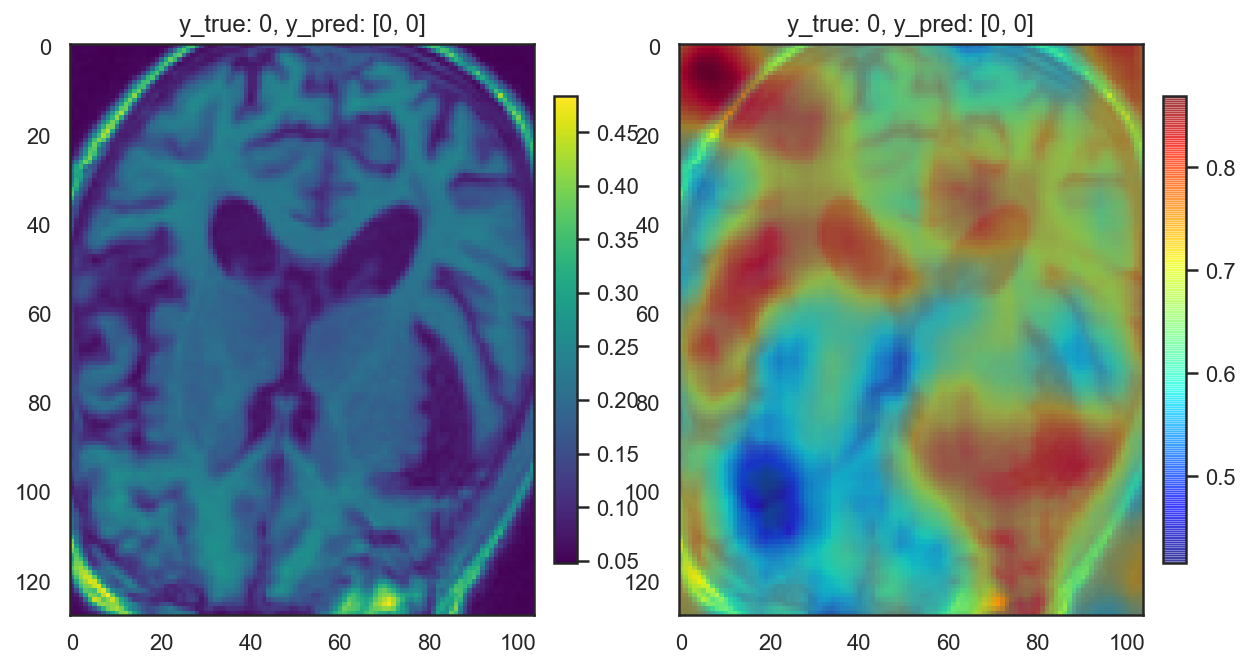

In [57]:
heatmaps.plot_heatmap_z(image_x, image_y, [0, 0], heatmap, 56)